# Landuse machine learning model -test-

This notebook integrates the first steps towards the development of a machine learning model for urban landuse prediction.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import aup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA



from keras import utils                                   # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers import Dense, Dropout, Activation  
from sklearn.preprocessing import LabelEncoder
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import utils  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,confusion_matrix

2025-07-29 16:27:42.286040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 16:27:42.341109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753828062.371190    9608 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753828062.379183    9608 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753828062.422798    9608 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data for model training

In [2]:
gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_prox.gpkg')
print(gdf.shape)
gdf.head(2)

(680000, 53)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,pobtot,...,denue_primaria_15min,denue_abarrotes,denue_abarrotes_15min,denue_peluqueria,denue_peluqueria_15min,denue_lavanderia,denue_lavanderia_15min,clues_primer_nivel,clues_primer_nivel_15min,geometry
0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,0,...,0.688413,11.817491,3.199180,12.878340,3.440951,13.706626,1.476592,18.913284,0.358167,"MULTIPOLYGON (((2349152.724 965335.704, 234914..."
1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,0,...,0.890523,11.070963,3.913038,12.435124,4.003971,13.505759,1.676774,16.916017,0.468920,"MULTIPOLYGON (((2349168.91 965335.176, 2349157..."


In [3]:
if 'fid' not in gdf.columns:
    gdf = gdf.reset_index().rename(columns={'index':'fid'})

In [4]:
gdf.columns

Index(['fid', 'uso_suelo', 'area_m2', 'full_plus_code', 'CVEGEO',
       'bld_area_m2', 'block_area_m2', 'pred_area_m2', 'pred_area_pct',
       'bld_pred_area_pct', 'pobtot', 'agropecuario', 'industria', 'servicios',
       'alojamiento', 'comercio', 'cultural_recreativo', 'educacion', 'salud',
       'gobierno', 'otros', 'area_m2_tot', 'habitacional', 'uso_tot',
       'pct_agropecuario', 'pct_industria', 'pct_servicios', 'pct_alojamiento',
       'pct_comercio', 'pct_cultural_recreativo', 'pct_educacion', 'pct_salud',
       'pct_gobierno', 'pct_otros', 'temperature_mean_diff', 'ndvi_mean',
       'ndmi_diff', 'motorway_distance', 'primary_distance',
       'secondary_distance', 'tertiary_distance', 'residential_distance',
       'other_distance', 'denue_primaria', 'denue_primaria_15min',
       'denue_abarrotes', 'denue_abarrotes_15min', 'denue_peluqueria',
       'denue_peluqueria_15min', 'denue_lavanderia', 'denue_lavanderia_15min',
       'clues_primer_nivel', 'clues_primer_nive

## Machine learning model

### Data preprocessing

Divide X and Y data

In [5]:
X = gdf[['bld_area_m2', 'block_area_m2', 'pred_area_m2', 'pred_area_pct',
       'bld_pred_area_pct','area_m2_tot',
        'pobtot', 'agropecuario', 'industria', 'servicios',
       'alojamiento', 'comercio', 'cultural_recreativo', 'educacion', 'salud',
       'gobierno', 'otros',  'habitacional', 
        'uso_tot',
       'pct_agropecuario', 'pct_industria', 'pct_servicios', 'pct_alojamiento',
       'pct_comercio', 'pct_cultural_recreativo', 'pct_educacion', 'pct_salud',
       'pct_gobierno', 'pct_otros', 
        'temperature_mean_diff', 'ndvi_mean',
       'ndmi_diff', 
        'motorway_distance', 'primary_distance',
       'secondary_distance', 'tertiary_distance', 'residential_distance',
       'other_distance', 
        'denue_primaria', 'denue_primaria_15min',
       'denue_abarrotes', 'denue_abarrotes_15min', 'denue_peluqueria',
       'denue_peluqueria_15min', 'denue_lavanderia', 'denue_lavanderia_15min',
       'clues_primer_nivel', 'clues_primer_nivel_15min'
    ]].to_numpy()

Y = gdf[['uso_suelo']].to_numpy()
Y = np.reshape(Y, shape=(Y.shape[0],))

Standarize and encode data

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Divide training, validation and testing data

In [7]:
X_model, X_test, y_model, y_test = (train_test_split(X_scaled, encoded_Y, test_size=0.2, random_state=0))

In [8]:
smote = SMOTE()  
X_resampled, y_resampled = smote.fit_resample(X_model, y_model)  

In [14]:
# X_train, X_val, y_train, y_val = (train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0))
X_train, X_val, y_train, y_val = (train_test_split(X_model, y_model, test_size=0.2, random_state=0))

Y data to categorical

In [15]:
# encode class values as integers
num_classes = len(gdf.uso_suelo.unique())

# convert integers to dummy variables (i.e. one hot encoded)
y_train = utils.to_categorical(y_train, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_val = utils.to_categorical(y_val, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_test = utils.to_categorical(y_test, num_classes)

### Model construction -- Classification Neural network

Model parameters

In [16]:
input_shape = (X_train.shape[1],)

In [17]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())
    

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           975 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 15)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,271 (32.31 KB)

 Trainable params: 8,271 (32.31 KB)

 Non-trainable params: 0 (0.00 B)

None


Model training

In [18]:
### Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val, y_val)
                   )

Epoch 1/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 9s 596us/step - acc: 0.7474 - loss: 0.9262 - val_acc: 0.7690 - val_loss: 0.7799
Epoch 2/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 561us/step - acc: 0.7634 - loss: 0.8094 - val_acc: 0.7716 - val_loss: 0.7643
Epoch 3/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 569us/step - acc: 0.7670 - loss: 0.7951 - val_acc: 0.7729 - val_loss: 0.7572
Epoch 4/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 583us/step - acc: 0.7662 - loss: 0.7887 - val_acc: 0.7754 - val_loss: 0.7496
Epoch 5/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 575us/step - acc: 0.7683 - loss: 0.7846 - val_acc: 0.7761 - val_loss: 0.7456
Epoch 6/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 575us/step - acc: 0.7678 - loss: 0.7837 - val_acc: 0.7766 - val_loss: 0.7433
Epoch 7/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 591us/step - acc: 0.7682 - loss: 0.7817 - val_acc: 0.7785 - val_loss: 0.7378
Epoch 8/200
13600/13600 ━━━━━━━━━━━━━━━━━━━━ 8s 574us/step - acc: 0.7699 - loss: 0.7762 - val_acc: 0.7765 - val_loss: 0.7396


Evaluate model

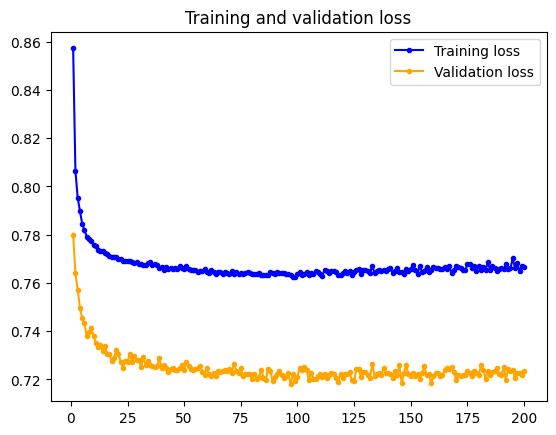

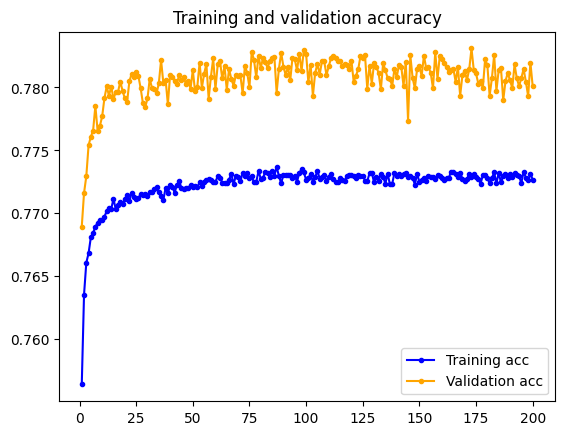

In [19]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [20]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
y_pred = model.predict(X_val)
print("Validation output shape:", y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val_trans = np.argmax(y_val, axis=1)
y_pred_trans = np.argmax(y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val_trans[:50])
print("Predicted validation labels:\t", y_pred_trans[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val_trans, y_pred_trans)
cm = np.transpose(cm)

labels = range(len(gdf['uso_suelo'].unique()))

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))
    

3400/3400 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
Validation output shape: (108800, 15)
Actual validation labels:	 [ 8  8  8 13  8  8  8  8  8  8  8  8  4  8 10  8  8  8  8  8  8  8 14  8
  5  8  8  8  8  6  8  8  8  8  4  4  8  8  9  8  8  8  8  8  4  8  8  8
  8  7]
Predicted validation labels:	 [8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 4]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)    (5)    (6)    (7)    (8)    (9)    (10)   (11)   (12)   (13)   (14)  
           0 (0):  [   399      0      2      1     84      8      0     13     24      7      2      2     12      4      3]
           1 (1):  [     0     22      0      0      0      1      0      0      0      1      0      0      2      3      0]
           2 (2):  [     0      0     14      0      2      0      0      1      0      0      0      0      0      0      0]
           3 (3):  [     0      0      0     75     20      0      1      0

## Apply model to the full dataset

Predict landuse for every element

In [21]:
y_hat = model.predict(X_scaled)

21250/21250 ━━━━━━━━━━━━━━━━━━━━ 6s 260us/step


Create prediction variables

In [22]:
category_list = ['agropecuario','alojamiento_temporal',
                 'area_libre','area_natural','baldio','comercio',
                'equipamiento','espacio_verde','habitacional',
                'industria','infraestructura','mixto','otros',
                 'servicio','sin_dato']

prefix = 'pct_pred_'

category_list = [prefix+cl for cl in category_list]
category_list

['pct_pred_agropecuario',
 'pct_pred_alojamiento_temporal',
 'pct_pred_area_libre',
 'pct_pred_area_natural',
 'pct_pred_baldio',
 'pct_pred_comercio',
 'pct_pred_equipamiento',
 'pct_pred_espacio_verde',
 'pct_pred_habitacional',
 'pct_pred_industria',
 'pct_pred_infraestructura',
 'pct_pred_mixto',
 'pct_pred_otros',
 'pct_pred_servicio',
 'pct_pred_sin_dato']

In [23]:
gdf[category_list] = y_hat
print(gdf.shape)
gdf.head(4)

(680000, 69)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,pct_pred_comercio,pct_pred_equipamiento,pct_pred_espacio_verde,pct_pred_habitacional,pct_pred_industria,pct_pred_infraestructura,pct_pred_mixto,pct_pred_otros,pct_pred_servicio,pct_pred_sin_dato
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,...,0.048883,0.015125,0.009697,0.124909,0.037659,0.000532,0.000438,0.000965,0.131072,0.474832
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,...,0.044894,0.039779,0.014653,0.224876,0.049750,0.000727,0.000704,0.001601,0.147022,0.363340
2,2,Sin dato,18.488100,75GRMGQW+8CHQ,1412000011206018,4.482118,278416.454431,18.488100,0.000066,0.242433,...,0.035207,0.075801,0.021603,0.356099,0.043229,0.000845,0.000879,0.002238,0.132652,0.234027
3,3,Sin dato,4.936089,75GRMGQW+8GCG,1412000011206018,42.992618,278416.454431,4.936089,0.000018,8.709855,...,0.035848,0.077465,0.021523,0.371731,0.043021,0.000862,0.001012,0.002396,0.132439,0.217409


Assign data to polygons

In [ ]:
# gdf['pred'] = y_hat.argmax(axis=1)

### Save model

In [ ]:
import pickle

In [31]:
model_name = 'landuse_nn_ModelSmote'
# pickle.dump(model, open(f"../../data/processed/prediccion_uso_suelo/complete_model/{model_name}.pkl", "wb"))

### Save output

In [32]:
# gdf.to_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_primera_pred.gpkg')

In [24]:
gdf.to_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_primera_pred_tmp.gpkg')